In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from transformers import ViTFeatureExtractor

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

def csv2labelnp(csv_file):
    label_df = pd.read_csv(csv_file, header=None)
    return label_df.loc[:,2:].to_numpy() / 10

def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

class FERPlusDataset(Dataset):
    def __init__(self, root, mode, threshold=0.3, transform=None):
        self.labels = csv2labelnp(os.path.join(root, 'label.csv'))
        self.samples = [os.path.join(root, img_name) for img_name in sorted(os.listdir(root))[:-1]]
        self.mode = mode
        self.threshold = threshold
        self.transform = transform
    
    def __getitem__(self, idx):
        img = pil_loader(self.samples[idx])
        if self.transform:
            img = self.transform(img)
        target = self.labels[idx]
        if self.mode == 'majority':
            target = np.argmax(target)
            target = torch.tensor(target)
        elif self.mode == 'multi-label':
            target = (target > self.threshold).astype(int)
            target = torch.from_numpy(target)
        else:
            target = torch.from_numpy(target)
        return img, target
    
    def __len__(self):
        return len(self.samples)

In [6]:
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    ToTensor,
                                    RandomAffine)

normalize = Normalize(mean=sum(feature_extractor.image_mean) / len(feature_extractor.image_mean),
                      std=sum(feature_extractor.image_std) / len(feature_extractor.image_std))

train_transform = Compose([RandomAffine(30),
                           Resize(tuple(feature_extractor.size.values())),
                           ToTensor()])

val_test_transform = Compose([Resize(tuple(feature_extractor.size.values())),
                              ToTensor()])

mode = 'majority'

train_dataset = FERPlusDataset('FERPlus/data/FER2013Train',
                               mode,
                               transform=train_transform)
val_dataset = FERPlusDataset('FERPlus/data/FER2013Valid',
                             mode,
                             transform=val_test_transform)
test_dataset = FERPlusDataset('FERPlus/data/FER2013Test',
                              mode,
                              transform=val_test_transform)

print('train:', len(train_dataset))
print('val:', len(val_dataset))
print('test:', len(test_dataset))

train: 28558
val: 3579
test: 3573


In [7]:
def collate_fn(examples):
    imgs, labels = zip(*examples)
    pixel_values = torch.stack(imgs)
    labels = torch.stack(labels)
    return {'pixel_values': pixel_values, 'labels': labels}

In [8]:
train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4)

batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [9]:
id2label = {
    0: 'neutral',
    1: 'happiness',
    2: 'surprise',
    3: 'sadness',
    4: 'anger',
    5: 'disgust',
    6: 'fear',
    7: 'contempt',
    8: 'unknown',
    9: 'NF'
}
label2id = {v:k for k,v in id2label.items()}

label2id

{'neutral': 0,
 'happiness': 1,
 'surprise': 2,
 'sadness': 3,
 'anger': 4,
 'disgust': 5,
 'fear': 6,
 'contempt': 7,
 'unknown': 8,
 'NF': 9}

In [8]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  num_labels=len(label2id),
                                                  label2id=label2id,
                                                  id2label=id2label)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"fer-majority-weightedloss-vit",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [10]:
from datasets import load_metric
import numpy as np

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

/tmp/ipykernel_991861/1052707893.py:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


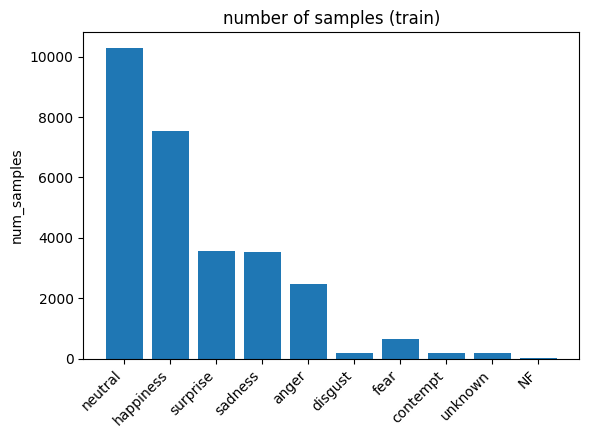

In [15]:
import matplotlib.pyplot as plt

label_sample_num = torch.tensor([0]*len(id2label))
for _, label in train_dataset:
    label = label.tolist()
    label_sample_num[label] += 1

x = torch.arange(1, len(label2id) + 1)
labels = list(id2label.values())
fig, ax = plt.subplots()
ax.bar(x=x, height=label_sample_num, tick_label=labels)
fig.autofmt_xdate(rotation=45)
ax.set_title('number of samples (train)')
ax.set_ylabel('num_samples')
plt.show()

In [11]:
label_ratio = label_sample_num / len(train_dataset)
weight = (1 / label_ratio).clone().to(device, torch.float32)
log_weight = (-torch.log(label_ratio)).clone().to(device, torch.float32)
log_weight[-2] = log_weight[-1] = 1
print(weight)
print(log_weight)

tensor([2.7740e+00, 3.7946e+00, 8.0287e+00, 8.0901e+00, 1.1595e+01, 1.4952e+02,
        4.3600e+01, 1.6999e+02, 1.6701e+02, 1.4279e+04], device='cuda:0')
tensor([1.0203, 1.3336, 2.0830, 2.0906, 2.4506, 5.0074, 3.7751, 5.1357, 1.0000,
        1.0000], device='cuda:0')


In [12]:
import torch.nn as nn
from torch.utils.data.sampler import WeightedRandomSampler

class WeightedLossTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get('labels')
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

class WeightedRandomSamplerTrainer(Trainer):
    def get_train_dataloader(self) -> DataLoader:
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset
        data_collator = self.data_collator
        return DataLoader(
            train_dataset,
            batch_size=self._train_batch_size,
            sampler=WeightedRandomSampler(weights=weight, num_samples=len(train_dataset)),
            collate_fn=data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

In [13]:
trainer = WeightedLossTrainer(
# trainer = WeightedRandomSamplerTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [14]:
trainer.train()

/home/rkn/.local/share/virtualenvs/lab-work-gFKfzxI5/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 28558
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8930
  Number of trainable parameters = 85806346
  6%|▌         | 500/8930 [02:31<42:32,  3.30it/s]

{'loss': 1.8624, 'learning_rate': 1.888017917133259e-05, 'epoch': 0.56}


 10%|█         | 893/8930 [04:31<34:58,  3.83it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                  
 10%|█         | 893/8930 [04:45<34:58,  3.83it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-893
Configuration saved in fer-majority-weightedloss-vit/checkpoint-893/config.json


{'eval_loss': 1.2344639301300049, 'eval_accuracy': 0.7205923442302319, 'eval_runtime': 13.9157, 'eval_samples_per_second': 257.191, 'eval_steps_per_second': 32.194, 'epoch': 1.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-893/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-893/preprocessor_config.json
 11%|█         | 1000/8930 [05:25<40:51,  3.24it/s]  

{'loss': 1.4557, 'learning_rate': 1.7760358342665175e-05, 'epoch': 1.12}


 17%|█▋        | 1500/8930 [07:59<38:27,  3.22it/s]

{'loss': 1.2995, 'learning_rate': 1.6640537513997762e-05, 'epoch': 1.68}


 20%|██        | 1786/8930 [09:27<30:59,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 20%|██        | 1786/8930 [09:41<30:59,  3.84it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-1786
Configuration saved in fer-majority-weightedloss-vit/checkpoint-1786/config.json


{'eval_loss': 1.0098140239715576, 'eval_accuracy': 0.7460184409052808, 'eval_runtime': 13.766, 'eval_samples_per_second': 259.989, 'eval_steps_per_second': 32.544, 'epoch': 2.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-1786/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-1786/preprocessor_config.json
 22%|██▏       | 2000/8930 [10:53<35:49,  3.22it/s]   

{'loss': 1.173, 'learning_rate': 1.552071668533035e-05, 'epoch': 2.24}


 28%|██▊       | 2500/8930 [13:26<32:19,  3.32it/s]

{'loss': 1.0778, 'learning_rate': 1.4400895856662935e-05, 'epoch': 2.8}


 30%|███       | 2679/8930 [14:21<26:56,  3.87it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 30%|███       | 2679/8930 [14:34<26:56,  3.87it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-2679
Configuration saved in fer-majority-weightedloss-vit/checkpoint-2679/config.json


{'eval_loss': 0.9126080274581909, 'eval_accuracy': 0.7728415758591786, 'eval_runtime': 13.6355, 'eval_samples_per_second': 262.477, 'eval_steps_per_second': 32.855, 'epoch': 3.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-2679/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-2679/preprocessor_config.json
 34%|███▎      | 3000/8930 [16:20<30:17,  3.26it/s]   

{'loss': 1.0058, 'learning_rate': 1.3281075027995522e-05, 'epoch': 3.36}


 39%|███▉      | 3500/8930 [18:54<27:42,  3.27it/s]

{'loss': 0.9538, 'learning_rate': 1.2161254199328107e-05, 'epoch': 3.92}


 40%|████      | 3572/8930 [19:16<23:28,  3.80it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 40%|████      | 3572/8930 [19:30<23:28,  3.80it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-3572
Configuration saved in fer-majority-weightedloss-vit/checkpoint-3572/config.json


{'eval_loss': 0.8545433282852173, 'eval_accuracy': 0.7588711930706902, 'eval_runtime': 13.7933, 'eval_samples_per_second': 259.473, 'eval_steps_per_second': 32.479, 'epoch': 4.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-3572/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-3572/preprocessor_config.json
 45%|████▍     | 4000/8930 [21:48<25:15,  3.25it/s]  

{'loss': 0.8815, 'learning_rate': 1.1041433370660695e-05, 'epoch': 4.48}


 50%|█████     | 4465/8930 [24:10<19:17,  3.86it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 50%|█████     | 4465/8930 [24:24<19:17,  3.86it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-4465
Configuration saved in fer-majority-weightedloss-vit/checkpoint-4465/config.json


{'eval_loss': 0.8038484454154968, 'eval_accuracy': 0.8018999720592345, 'eval_runtime': 13.6411, 'eval_samples_per_second': 262.369, 'eval_steps_per_second': 32.842, 'epoch': 5.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-4465/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-4465/preprocessor_config.json
 50%|█████     | 4500/8930 [24:42<22:40,  3.26it/s]  

{'loss': 0.8376, 'learning_rate': 9.921612541993282e-06, 'epoch': 5.04}


 56%|█████▌    | 5000/8930 [27:14<19:52,  3.30it/s]

{'loss': 0.7763, 'learning_rate': 8.801791713325869e-06, 'epoch': 5.6}


 60%|██████    | 5358/8930 [29:04<15:31,  3.83it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 60%|██████    | 5358/8930 [29:18<15:31,  3.83it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-5358
Configuration saved in fer-majority-weightedloss-vit/checkpoint-5358/config.json


{'eval_loss': 0.8163604736328125, 'eval_accuracy': 0.7924001117630624, 'eval_runtime': 13.7449, 'eval_samples_per_second': 260.388, 'eval_steps_per_second': 32.594, 'epoch': 6.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-5358/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-5358/preprocessor_config.json
 62%|██████▏   | 5500/8930 [30:08<17:28,  3.27it/s]  

{'loss': 0.7468, 'learning_rate': 7.681970884658456e-06, 'epoch': 6.16}


 67%|██████▋   | 6000/8930 [32:42<15:08,  3.22it/s]

{'loss': 0.6898, 'learning_rate': 6.562150055991042e-06, 'epoch': 6.72}


 70%|███████   | 6251/8930 [34:00<11:38,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 70%|███████   | 6251/8930 [34:13<11:38,  3.84it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-6251
Configuration saved in fer-majority-weightedloss-vit/checkpoint-6251/config.json


{'eval_loss': 0.8055374026298523, 'eval_accuracy': 0.8074881251746298, 'eval_runtime': 13.7849, 'eval_samples_per_second': 259.632, 'eval_steps_per_second': 32.499, 'epoch': 7.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-6251/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-6251/preprocessor_config.json
 73%|███████▎  | 6500/8930 [35:39<12:26,  3.25it/s]  

{'loss': 0.678, 'learning_rate': 5.442329227323628e-06, 'epoch': 7.28}


 78%|███████▊  | 7000/8930 [38:11<09:45,  3.29it/s]

{'loss': 0.6349, 'learning_rate': 4.322508398656216e-06, 'epoch': 7.84}


 80%|████████  | 7144/8930 [38:54<07:38,  3.89it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 80%|████████  | 7144/8930 [39:08<07:38,  3.89it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-7144
Configuration saved in fer-majority-weightedloss-vit/checkpoint-7144/config.json


{'eval_loss': 0.8051640391349792, 'eval_accuracy': 0.8113998323554066, 'eval_runtime': 13.6416, 'eval_samples_per_second': 262.36, 'eval_steps_per_second': 32.841, 'epoch': 8.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-7144/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-7144/preprocessor_config.json
 84%|████████▍ | 7500/8930 [41:06<07:23,  3.22it/s]  

{'loss': 0.581, 'learning_rate': 3.202687569988802e-06, 'epoch': 8.4}


 90%|████████▉ | 8000/8930 [43:41<04:47,  3.23it/s]

{'loss': 0.5733, 'learning_rate': 2.082866741321389e-06, 'epoch': 8.96}


 90%|█████████ | 8037/8930 [43:52<03:55,  3.80it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
 90%|█████████ | 8037/8930 [44:06<03:55,  3.80it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-8037
Configuration saved in fer-majority-weightedloss-vit/checkpoint-8037/config.json


{'eval_loss': 0.8016127347946167, 'eval_accuracy': 0.8074881251746298, 'eval_runtime': 13.7567, 'eval_samples_per_second': 260.164, 'eval_steps_per_second': 32.566, 'epoch': 9.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-8037/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-8037/preprocessor_config.json
 95%|█████████▌| 8500/8930 [46:36<02:13,  3.21it/s]  

{'loss': 0.5491, 'learning_rate': 9.630459126539753e-07, 'epoch': 9.52}


100%|██████████| 8930/8930 [48:48<00:00,  3.84it/s]***** Running Evaluation *****
  Num examples = 3579
  Batch size = 8
                                                   
100%|██████████| 8930/8930 [49:01<00:00,  3.84it/s]Saving model checkpoint to fer-majority-weightedloss-vit/checkpoint-8930
Configuration saved in fer-majority-weightedloss-vit/checkpoint-8930/config.json


{'eval_loss': 0.7989436984062195, 'eval_accuracy': 0.8113998323554066, 'eval_runtime': 13.6054, 'eval_samples_per_second': 263.057, 'eval_steps_per_second': 32.928, 'epoch': 10.0}


Model weights saved in fer-majority-weightedloss-vit/checkpoint-8930/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/checkpoint-8930/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from fer-majority-weightedloss-vit/checkpoint-7144 (score: 0.8113998323554066).
100%|██████████| 8930/8930 [49:10<00:00,  3.03it/s]

{'train_runtime': 2950.7945, 'train_samples_per_second': 96.781, 'train_steps_per_second': 3.026, 'train_loss': 0.9090673875968908, 'epoch': 10.0}


TrainOutput(global_step=8930, training_loss=0.9090673875968908, metrics={'train_runtime': 2950.7945, 'train_samples_per_second': 96.781, 'train_steps_per_second': 3.026, 'train_loss': 0.9090673875968908, 'epoch': 10.0})

In [15]:
trainer.save_state()
trainer.save_model()

Saving model checkpoint to fer-majority-weightedloss-vit
Configuration saved in fer-majority-weightedloss-vit/config.json
Model weights saved in fer-majority-weightedloss-vit/pytorch_model.bin
Image processor saved in fer-majority-weightedloss-vit/preprocessor_config.json


In [16]:
outputs = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 3573
  Batch size = 8
100%|██████████| 447/447 [00:13<00:00, 33.36it/s]


In [17]:
print(outputs.metrics)

{'test_loss': 0.8674798011779785, 'test_accuracy': 0.799328295549958, 'test_runtime': 13.44, 'test_samples_per_second': 265.848, 'test_steps_per_second': 33.259}


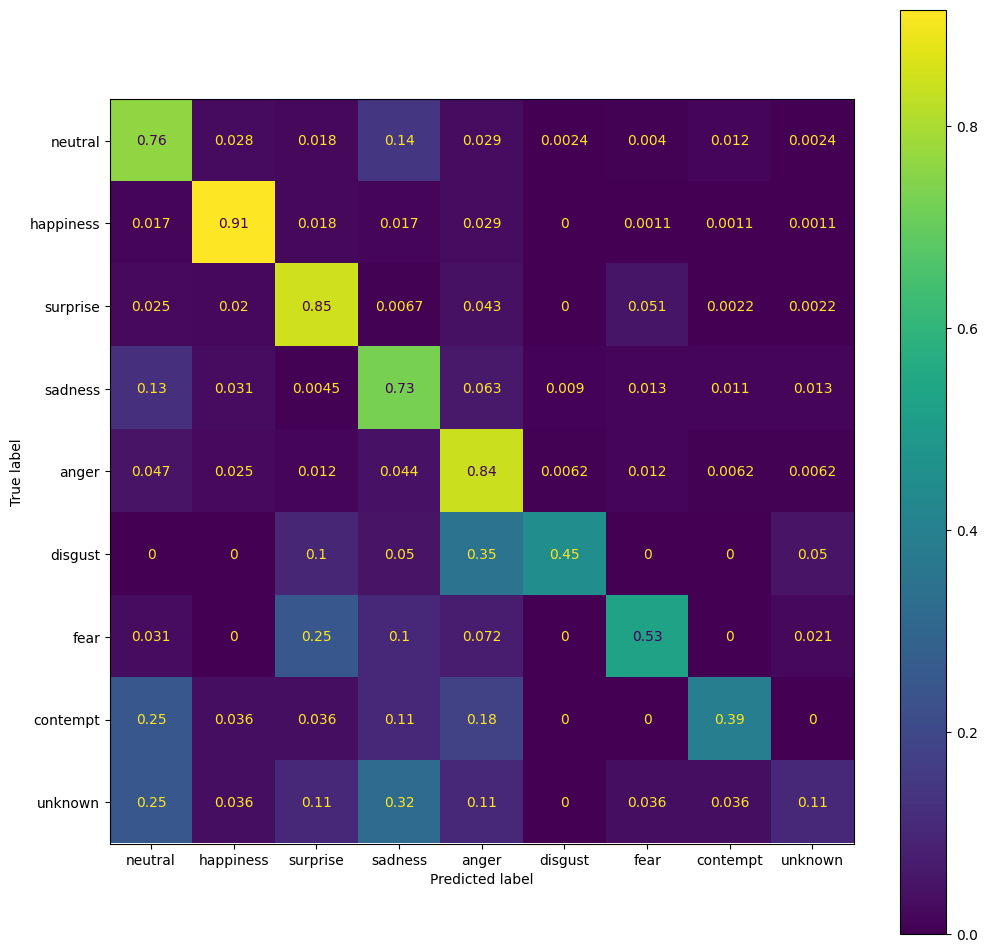

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = list(label2id.keys())[:-1]
cm = confusion_matrix(y_true, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)

In [19]:
from tqdm import tqdm

def CLE_tokens(model, tokenizer, dataset, device):
    tokens = []
    labels = []
    for img, label in tqdm(dataset):
        feature = tokenizer(img, return_tensors='pt').pixel_values.to(device)
        with torch.no_grad():
            token = model(feature, output_hidden_states=True).hidden_states[-1][0,0,:]
        tokens.append(token.cpu())
        labels.append(label)
    return torch.stack(tokens).squeeze(), torch.tensor(labels)

In [20]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import random

def plot_tokens(tokens, labels, n_neighbors):
    # tsne = TSNE(n_components=2)
    # zs = tsne.fit_transform(tokens.numpy())
    umap = UMAP(n_neighbors=n_neighbors)
    zs = umap.fit_transform(tokens.numpy())
    ys = labels.numpy()
    print(zs.shape)
    print(ys.shape)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.set_xlabel('feature-1')
    ax.set_ylabel('feature-2')
    cmap = cm.get_cmap('gist_ncar')
    
    label2point = {}
    for x, y in zip(zs, ys):
        mp = ax.scatter(x[0], x[1],
                        alpha=1,
                        label=id2label[y],
                        # c=label2color[y],
                        c=y,
                        cmap=cmap,
                        vmin=0,
                        vmax=len(set(ys)),
                        s=3,)
        label2point[id2label[y]] = mp
    labels, handles = zip(*sorted(label2point.items()))
    fig.legend(handles, labels, loc='right')
    plt.show()


In [21]:
from transformers import ViTForImageClassification

non_finetuned_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                                num_labels=len(label2id),
                                                                label2id=label2id,
                                                                id2label=id2label)

loading configuration file config.json from cache at /home/rkn/.cache/huggingface/hub/models--google--vit-base-patch16-224-in21k/snapshots/1ba429d32753f33a0660b80ac6f43a3c80c18938/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "neutral",
    "1": "happiness",
    "2": "surprise",
    "3": "sadness",
    "4": "anger",
    "5": "disgust",
    "6": "fear",
    "7": "contempt",
    "8": "unknown",
    "9": "NF"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NF": 9,
    "anger": 4,
    "contempt": 7,
    "disgust": 5,
    "fear": 6,
    "happiness": 1,
    "neutral": 0,
    "sadness": 3,
    "surprise": 2,
    "unknown": 8
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_att

100%|██████████| 3573/3573 [00:32<00:00, 110.34it/s]


(3573, 2)
(3573,)


/tmp/ipykernel_991861/802266291.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


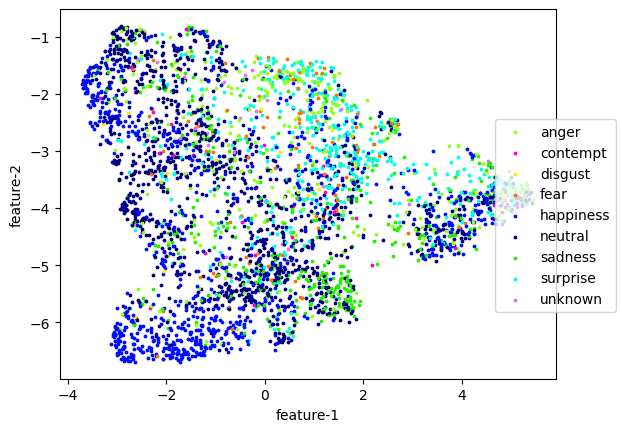

In [22]:
tokens, labels = CLE_tokens(non_finetuned_model.to(device),
                            feature_extractor,
                            test_dataset,
                            device)
plot_tokens(tokens, labels, 75)

In [23]:
finetuned_model = ViTForImageClassification.from_pretrained('fer-majority-weightedloss-vit/',
                                                            num_labels=len(label2id),
                                                            label2id=label2id,
                                                            id2label=id2label).to(device)

loading configuration file fer-majority-weightedloss-vit/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "neutral",
    "1": "happiness",
    "2": "surprise",
    "3": "sadness",
    "4": "anger",
    "5": "disgust",
    "6": "fear",
    "7": "contempt",
    "8": "unknown",
    "9": "NF"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NF": 9,
    "anger": 4,
    "contempt": 7,
    "disgust": 5,
    "fear": 6,
    "happiness": 1,
    "neutral": 0,
    "sadness": 3,
    "surprise": 2,
    "unknown": 8
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "

100%|██████████| 3573/3573 [02:21<00:00, 25.33it/s]


(3573, 2)
(3573,)


/tmp/ipykernel_991861/802266291.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('gist_ncar')


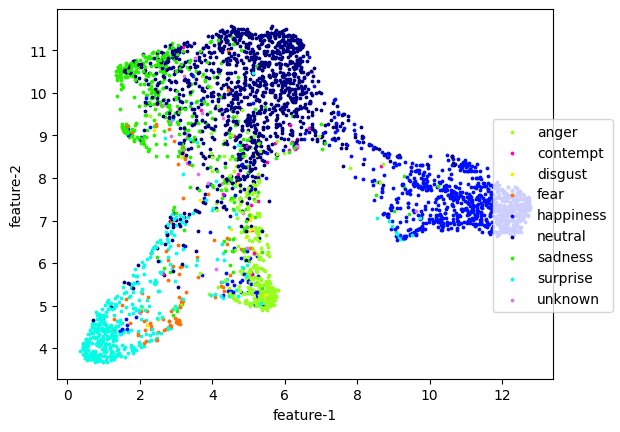

In [24]:
tokens, labels = CLE_tokens(finetuned_model,
                            feature_extractor,
                            test_dataset,
                            device)
plot_tokens(tokens, labels, 75)